# Precog Recruitment Task

## Part 1: Dense Representations

In [2]:
%pip install numpy pandas nltk scipy scikit-learn matplotlib torch tensorboard plotly nbformat gensim transformers fasttext cupy-cuda12x faiss-gpu-cu12 wefe tqdm ipywidgets tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


### 1.1: Creating Cooccurance Matrix

In [ ]:
import nltk
import scipy
import csv
import pickle

nltk.download('punkt_tab')
nltk.download('stopwords')

sentences=[]
token_dict = {}
id_to_token = {}
token_id = 0

cooccur_dict = {}
max_cooccur = 0
max_pair = ()

row_count = {}
col_count = {}

stop_words = set(nltk.corpus.stopwords.words('english'))

with open("eng_news_2020_1M/eng_news_2020_1M-sentences.txt", "r") as doc:
    for line in doc:
        tokens = nltk.word_tokenize(line)
        cleared_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and (any(c.isalpha() for c in token))]
        sentences.append(cleared_tokens)
        for token in cleared_tokens:
            if token not in token_dict:
                token_dict[token] = token_id
                id_to_token[token_id] = token
                token_id += 1

        for i in range(len(cleared_tokens)):
            left = max(0, i - 2)
            right = min(len(cleared_tokens), i + 3)
            window = range(left, right)

            for j in window:
                pair = (token_dict[cleared_tokens[i]], token_dict[cleared_tokens[j]])
                if pair[0] != pair[1]:
                    if pair not in cooccur_dict:
                        cooccur_dict[pair] = 1
                        cooccur_dict[(pair[1], pair[0])] = 1
                    else:
                        cooccur_dict[pair] += 1
                        cooccur_dict[(pair[1], pair[0])] += 1
                else:
                    if pair not in cooccur_dict:
                        cooccur_dict[pair] = 1
                    else:
                        cooccur_dict[pair] += 1
                
                if(cooccur_dict[pair] > max_cooccur):
                        max_cooccur = cooccur_dict[pair]
                        max_pair = pair
                    

                    

rows = []
cols = []
values = []

for (token_id1, token_id2), count in cooccur_dict.items():
    rows.append(token_id1)
    cols.append(token_id2)
    values.append(count)

n = len(token_dict)

cooccur_matrix_coo = scipy.sparse.coo_array((values, (rows, cols)), shape=(n, n))
scipy.sparse.save_npz("cooccur_matrix/cooccur_matrix_coo.npz", cooccur_matrix_coo)

# Save as file for later
with open("dictionaries/token_dict.bin", "wb") as binfile:
    pickle.dump(token_dict, binfile)

with open("dictionaries/id_to_token.bin", "wb") as binfile:
    pickle.dump(id_to_token, binfile)

with open("dictionaries/token_dict.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["token", "id"])
    for token, id in token_dict.items():
        writer.writerow([token, id])

with open("dictionaries/cooccur_dict.bin", "wb") as binfile:
    pickle.dump(cooccur_dict, binfile)

with open("dictionaries/coccur_dict.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["token_1", "token_2", "cooccur_amount"])
    for (token_id1, token_id2), cooccur_amount in cooccur_dict.items():
        token1 = id_to_token[token_id1]
        token2 = id_to_token[token_id2]
        writer.writerow([token1, token2, cooccur_amount])

# Clear memory
del sentences, token_dict, id_to_token, cooccur_dict, row_count, col_count, stop_words, rows, cols, values, cooccur_matrix_coo

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/anirudhsankar23/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anirudhsankar23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2: Dimensionality Reduction

In [ ]:
import scipy.sparse
import scipy.sparse.linalg
import numpy as np

cooccur_matrix_coo = scipy.sparse.load_npz("cooccur_matrix/cooccur_matrix_coo.npz")

# Had the "extremely smart" idea of making vectors of dimensions as the largest no. of non-zero values in a row which is 48536
# row_counts = np.bincount(cooccur_matrix_coo.row, minlength=cooccur_matrix_coo.shape[0])
# max_non_zero_row = np.max(row_counts)
# print(max_non_zero_row)

U, S, Vt = scipy.sparse.linalg.svds(cooccur_matrix_coo, solver='propack', k=30)
np.save("word_embeddings/word_embeddings_30_dims", U)
print(U.shape)
del U
del S
del Vt

U, S, Vt = scipy.sparse.linalg.svds(cooccur_matrix_coo, solver='propack', k=100)
np.save("word_embeddings/word_embeddings_100_dims", U)
print(U.shape)
del U
del S
del Vt

# # Can crash; uncomment and run seperately
U, S, Vt = scipy.sparse.linalg.svds(cooccur_matrix_coo, solver='propack', k=300)
np.save("word_embeddings/word_embeddings_300_dims", U)
print(U.shape)
del U
del S
del Vt

# u, s, vh = scipy.sparse.linalg.svds(cooccur_matrix_coo, k=500)
# np.save("word_embeddings/word_embeddings_500_dims", u)
# print(u.shape)

# u, s, vh = scipy.sparse.linalg.svds(cooccur_matrix_coo, k=1000)
# np.save("word_embeddings/word_embeddings_600_dims", u)
# print(u.shape)

del cooccur_matrix_coo

(304951, 300)


### 1.3: Evaluation of Quality

#### Semantic Similarity Evaluation

In [2]:
import numpy as np
import scipy
import pickle

file = open("dictionaries/token_dict.bin", "rb")
token_dict = pickle.load(file)
print(len(token_dict))

word_embedding_30_dim = np.load("word_embeddings/word_embeddings_30_dims.npy")
word_embedding_100_dim = np.load("word_embeddings/word_embeddings_100_dims.npy")
word_embedding_300_dim = np.load("word_embeddings/word_embeddings_300_dims.npy")
word_embedding_500_dim = np.load("word_embeddings/word_embeddings_500_dims.npy")

men_scores = []
simlex_999_scores = []
wordsim353_scores = []

with open("MEN/MEN_dataset_natural_form_full", "r") as file:
    for line in file:
        word1, word2, score = line.split()
        if (word1 in token_dict.keys()) and (word2 in token_dict.keys()):
            men_scores.append((word1, word2, score))
            # print(word1, word2, score)
    file.close()
print(len(men_scores))

with open("SimLex-999/SimLex-999.txt", "r") as file:
    for line in file:
        temp = line.split('\t')
        word1, word2, score = temp[0], temp[1], temp[3]
        if (word1 in token_dict.keys()) and (word2 in token_dict.keys()):
            simlex_999_scores.append((word1, word2, score))
            # print(word1, word2, score)
    file.close()
print(len(simlex_999_scores))

with open("wordsim353/combined.tab", "r") as file:
    for line in file:
        word1, word2, score = line.split('\t')
        if (word1 in token_dict.keys()) and (word2 in token_dict.keys()):
            wordsim353_scores.append((word1, word2, score))
            # print(word1, word2, score)
    file.close()
print(len(wordsim353_scores))
print()

# Calculate Spearman correlation
datasets = [men_scores, simlex_999_scores, wordsim353_scores]

for i in range(len(datasets)):
    dataset_score = []
    word_embedding_30_dim_cosine = []
    word_embedding_100_dim_cosine = []
    word_embedding_300_dim_cosine = []
    word_embedding_500_dim_cosine = []

    for word1, word2, score in datasets[i]:
        token_id1 = token_dict[word1]
        token_id2 = token_dict[word2]

        embedding_sim_30 = np.dot(word_embedding_30_dim[token_id1], word_embedding_30_dim[token_id2]) / \
                            (np.linalg.norm(word_embedding_30_dim[token_id1]) * np.linalg.norm(word_embedding_30_dim[token_id2]))
        
        embedding_sim_100 = np.dot(word_embedding_100_dim[token_id1], word_embedding_100_dim[token_id2]) / \
                            (np.linalg.norm(word_embedding_100_dim[token_id1]) * np.linalg.norm(word_embedding_100_dim[token_id2]))
        
        embedding_sim_300 = np.dot(word_embedding_300_dim[token_id1], word_embedding_300_dim[token_id2]) / \
                            (np.linalg.norm(word_embedding_300_dim[token_id1]) * np.linalg.norm(word_embedding_300_dim[token_id2]))
        
        embedding_sim_500 = np.dot(word_embedding_500_dim[token_id1], word_embedding_500_dim[token_id2]) / \
                            (np.linalg.norm(word_embedding_500_dim[token_id1]) * np.linalg.norm(word_embedding_500_dim[token_id2]))
        
        dataset_score.append(float(score))
        word_embedding_30_dim_cosine.append(embedding_sim_30)
        word_embedding_100_dim_cosine.append(embedding_sim_100)
        word_embedding_300_dim_cosine.append(embedding_sim_300)
        word_embedding_500_dim_cosine.append(embedding_sim_500)

    corr_30_dim, p_value_30 = scipy.stats.spearmanr(word_embedding_30_dim_cosine, dataset_score)
    corr_100_dim, p_value_100 = scipy.stats.spearmanr(word_embedding_100_dim_cosine, dataset_score)
    corr_300_dim, p_value_300 = scipy.stats.spearmanr(word_embedding_300_dim_cosine, dataset_score)
    corr_500_dim, p_value_500 = scipy.stats.spearmanr(word_embedding_500_dim_cosine, dataset_score)

    if i == 0:
        print("Results for MEN Dataset:")
    elif i == 1:
        print("Results for SimLex-999 Dataset:")
    else:
        print("Results for wordsim353 Dataset:")
    print(f"30-dim Word Embeddings: Correlation = {corr_30_dim}, P-value = {p_value_30: .4f}")
    print(f"100-dim Word Embeddings: Correlation = {corr_100_dim}, P-value = {p_value_100: .4f}")
    print(f"300-dim Word Embeddings: Correlation = {corr_300_dim}, P-value = {p_value_300: .4f}")
    print(f"500-dim Word Embeddings: Correlation = {corr_500_dim}, P-value = {p_value_500: .4f}")
    print()

    del dataset_score
    del word_embedding_30_dim_cosine
    del word_embedding_100_dim_cosine
    del word_embedding_300_dim_cosine
    del word_embedding_500_dim_cosine

    del corr_30_dim
    del corr_100_dim
    del corr_300_dim
    del corr_500_dim

    del p_value_30
    del p_value_100
    del p_value_300
    del p_value_500

# Clear memory
del token_dict

del word_embedding_30_dim
del word_embedding_100_dim
del word_embedding_300_dim
del word_embedding_500_dim

del men_scores
del simlex_999_scores
del wordsim353_scores

304951
2998
994
335

Results for MEN Dataset:
30-dim Word Embeddings: Correlation = 0.17976641112053654, P-value =  0.0000
100-dim Word Embeddings: Correlation = 0.27246768234887525, P-value =  0.0000
300-dim Word Embeddings: Correlation = 0.3680098798748443, P-value =  0.0000
500-dim Word Embeddings: Correlation = 0.43062553157199057, P-value =  0.0000

Results for SimLex-999 Dataset:
30-dim Word Embeddings: Correlation = 0.08168387052665366, P-value =  0.0100
100-dim Word Embeddings: Correlation = 0.10610723173818977, P-value =  0.0008
300-dim Word Embeddings: Correlation = 0.1686126448848569, P-value =  0.0000
500-dim Word Embeddings: Correlation = 0.18140022389740237, P-value =  0.0000

Results for wordsim353 Dataset:
30-dim Word Embeddings: Correlation = 0.18998775084983613, P-value =  0.0005
100-dim Word Embeddings: Correlation = 0.27751872293833185, P-value =  0.0000
300-dim Word Embeddings: Correlation = 0.3045894928855581, P-value =  0.0000
500-dim Word Embeddings: Correlation

#### Visualizing Word Embeddings

##### 2D Visualization using Matplotlib

In [ ]:
import numpy as np
import pickle
import sklearn
import gc

file = open("dictionaries/token_dict.bin", "rb")
token_dict = pickle.load(file)

# Find the top n tokens
n = 76238 # 25% of the total tokens
file = open("eng_news_2020_1M/eng_news_2020_1M-words.txt", "r")
top_n_tokens = []
for line in file:
    id, token, freq = line.split('\t')
    if token in token_dict.keys():
        top_n_tokens.append(token)
    if len(top_n_tokens) == n:
        break
file.close()


# Save top n token labels (for visualization)
with open("tensorboard-visualization/top_25percent_tokens.tsv", 'w') as f:
    for token in top_n_tokens:
        f.write(f"{token}\n")

word_embedding = np.load("word_embeddings/word_embeddings_300_dims.npy")



tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=50, max_iter=1000)
tsne3D = sklearn.manifold.TSNE(n_components=3, random_state=0, perplexity=50, max_iter=1000)

# For all tokens
word_embedding_tsne = tsne.fit_transform(word_embedding)
np.save("word_embeddings/word_embeddings_500_tsne", word_embedding_tsne)
del word_embedding_tsne
gc.collect()

# For top n tokens
top_n_tokens_embedding = np.array([word_embedding[token_dict[token]] for token in top_n_tokens])
del word_embedding, token_dict, top_n_tokens
gc.collect()

np.save("word_embeddings/top_25percent_tokens_embedding", top_n_tokens_embedding)
top_n_tokens_embedding_tsne = tsne.fit_transform(top_n_tokens_embedding)
np.save("word_embeddings/top_25percent_tokens_embedding_tsne", top_n_tokens_embedding_tsne)
top_n_tokens_embedding_tsne3D = tsne3D.fit_transform(top_n_tokens_embedding)
np.save("word_embeddings/top_25percent_tokens_embedding_tsne3D", top_n_tokens_embedding_tsne3D)


del top_n_tokens_embedding, top_n_tokens_embedding_tsne, top_n_tokens_embedding_tsne3D
gc.collect()

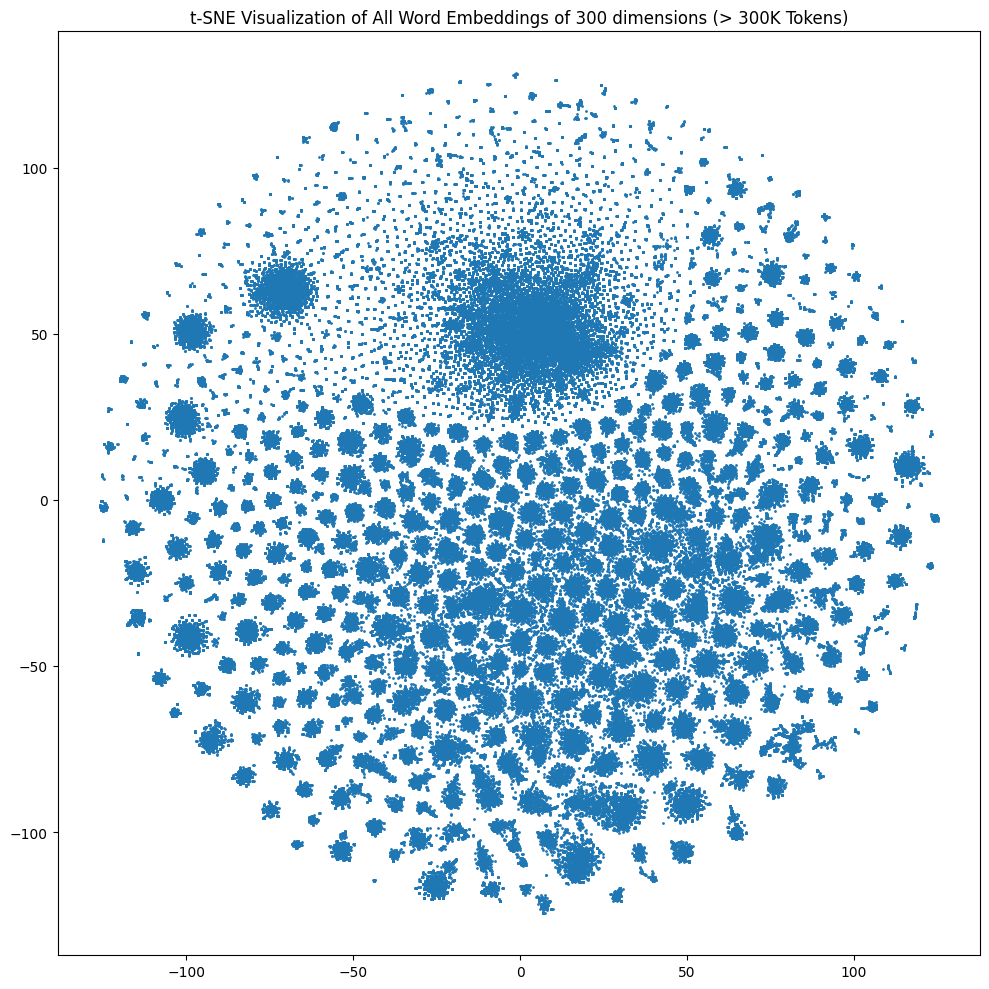

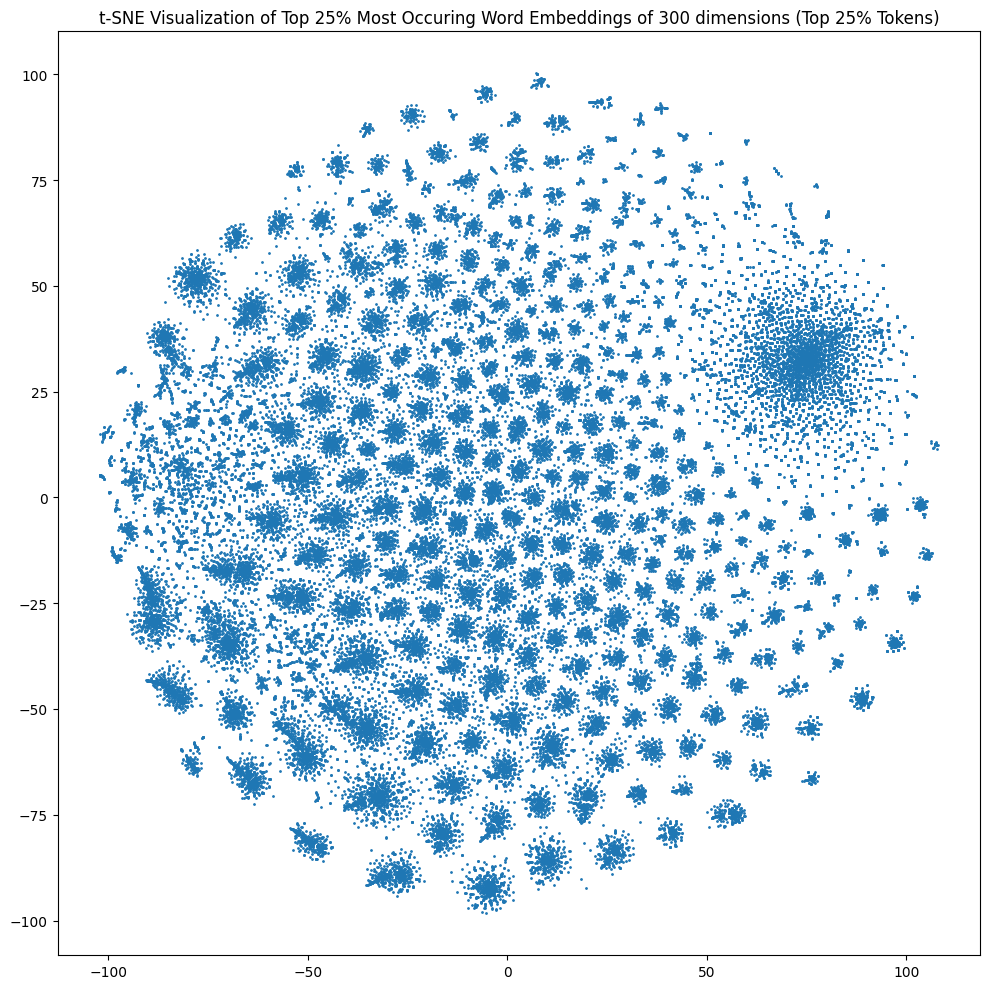

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

word_embedding_300_tsne = np.load("word_embeddings/word_embeddings_300_tsne.npy")
top_n_tokens_embedding_tsne = np.load("word_embeddings/top_25percent_tokens_embedding_tsne.npy")

file = open("dictionaries/id_to_token.bin", "rb")
id_to_token = pickle.load(file)
file.close()

plt.figure(figsize=(10, 10))
plt.scatter(word_embedding_300_tsne[:, 0], word_embedding_300_tsne[:, 1], s=1)
plt.title("t-SNE Visualization of All Word Embeddings of 300 dimensions (> 300K Tokens)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(top_n_tokens_embedding_tsne[:, 0], top_n_tokens_embedding_tsne[:, 1], s=1)
plt.title("t-SNE Visualization of Top 25% Most Occuring Word Embeddings of 300 dimensions (Top 25% Tokens)")
plt.tight_layout()
plt.show()

del word_embedding_300_tsne
del top_n_tokens_embedding_tsne
del id_to_token

##### 3D Visualization of Top 25 percent most frequently occured words

Using Plotly

In [ ]:
import numpy as np
import pandas as pd
import plotly
import nbformat

import plotly.express

file = open("tensorboard-visualization/top_25percent_tokens.tsv", "r")
top_n_tokens = [line.strip() for line in file]
file.close()

word_embedding_tsne3D = np.load("word_embeddings/top_25percent_tokens_embedding_tsne3D.npy")

df = pd.DataFrame(word_embedding_tsne3D, columns=['x', 'y', 'z'])

df['token'] = top_n_tokens

fig = plotly.express.scatter_3d(df, x='x', y='y', z='z', hover_data=['token'])
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="t-SNE 3D Visualization of Top 25% Most Occuring Word Embeddings", scene=dict(xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', zaxis_title='t-SNE Component 3'), height=800, width=800)
fig.show()

# Clear memory
del top_n_tokens
del word_embedding_tsne3D
del df
del fig

Using Tensorboard

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

top_n_tokens = []
with open("tensorboard-visualization/top_25percent_tokens.tsv", "r") as file:
    for line in file:
        top_n_tokens.append(line.strip())

word_embedding = np.load("word_embeddings/top_25percent_tokens_embedding.npy")
embeddings = torch.from_numpy(word_embedding)
print(embeddings.shape)
# Save embeddings

writer = SummaryWriter("tensorboard-visualization")
writer.add_embedding(embeddings, metadata=top_n_tokens)
writer.close()

del top_n_tokens, word_embedding, embeddings

torch.Size([76238, 300])


In [5]:
%load_ext tensorboard
%tensorboard --logdir "tensorboard-visualization"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 186537), started 0:02:27 ago. (Use '!kill 186537' to kill it.)

### 1.4: Analysis of Neural-based Embeddings

#### Semantic Similarity Evaluation

##### 1. word2vec

In [ ]:
import gensim
import scipy

word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

# Extract vocabulary
vocab = []
for word in word2vec.key_to_index:
    vocab.append(word)

men_scores = []
simlex_999_scores = []
wordsim353_scores = []

with open("MEN/MEN_dataset_natural_form_full", "r") as file:
    for line in file:
        word1, word2, score = line.split()
        if (word1 in vocab) and (word2 in vocab):
            men_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(men_scores))

with open("SimLex-999/SimLex-999.txt", "r") as file:
    for line in file:
        temp = line.split('\t')
        word1, word2, score = temp[0], temp[1], temp[3]
        if (word1 in vocab) and (word2 in vocab):
            simlex_999_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(simlex_999_scores))

with open("wordsim353/combined.tab", "r") as file:
    for line in file:
        word1, word2, score = line.split('\t')
        if (word1 in vocab) and (word2 in vocab):
            wordsim353_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(wordsim353_scores))
print()

# Calculate Spearman correlation
datasets = [men_scores, simlex_999_scores, wordsim353_scores]

for i in range(len(datasets)):
    dataset_score = []
    word2vec_cosine = []

    for word1, word2, score in datasets[i]:
        embedding_sim = word2vec.similarity(word1, word2)
        
        dataset_score.append(float(score))
        word2vec_cosine.append(embedding_sim)

    corr, p_value = scipy.stats.spearmanr(word2vec_cosine, dataset_score)

    if i == 0:
        print("Results for MEN Dataset:")
    elif i == 1:
        print("Results for SimLex-999 Dataset:")
    else:
        print("Results for wordsim353 Dataset:")

    print(f"Word2Vec: Correlation = {corr}, P-value = {p_value: .4f}")
    print()

del word2vec, vocab, men_scores, simlex_999_scores, wordsim353_scores, datasets

2946
999
353

Results for MEN Dataset:
Word2Vec: Correlation = 0.7819958890602363, P-value =  0.0000

Results for SimLex-999 Dataset:
Word2Vec: Correlation = 0.44196551091403796, P-value =  0.0000

Results for wordsim353 Dataset:
Word2Vec: Correlation = 0.7000166486272194, P-value =  0.0000



##### 2. GloVe

In [ ]:
import numpy as np
import pickle

embeddings = {}
with open('glove.840B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector

dumpfile = open('dictionaries/glove_embeddings.bin', 'wb')
pickle.dump(embeddings, dumpfile)

del embeddings

In [ ]:
import pickle
import scipy
import numpy as np

file = open("dictionaries/glove_embeddings.bin", "rb")
glove_embeddings = pickle.load(file)

# Extract vocabulary
vocab = glove_embeddings.keys()

men_scores = []
simlex_999_scores = []
wordsim353_scores = []

with open("MEN/MEN_dataset_natural_form_full", "r") as file:
    for line in file:
        word1, word2, score = line.split()
        if (word1 in vocab) and (word2 in vocab):
            men_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(men_scores))

with open("SimLex-999/SimLex-999.txt", "r") as file:
    for line in file:
        temp = line.split('\t')
        word1, word2, score = temp[0], temp[1], temp[3]
        try:
            score = float(score)
        except:
            continue
        if (word1 in vocab) and (word2 in vocab):
            simlex_999_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(simlex_999_scores))

with open("wordsim353/combined.tab", "r") as file:
    for line in file:
        word1, word2, score = line.split('\t')
        try:
            score = float(score)
        except:
            continue
        if (word1 in vocab) and (word2 in vocab):
            wordsim353_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(wordsim353_scores))
print()

# Calculate Spearman correlation
datasets = [men_scores, simlex_999_scores, wordsim353_scores]

for i in range(len(datasets)):
    dataset_score = []
    GloVe_cosine = []

    for word1, word2, score in datasets[i]:
        embedding_sim = np.dot(glove_embeddings[word1], glove_embeddings[word2]) / \
                        (np.linalg.norm(glove_embeddings[word1]) * np.linalg.norm(glove_embeddings[word2]))

        dataset_score.append(float(score))
        GloVe_cosine.append(embedding_sim)

    corr, p_value = scipy.stats.spearmanr(GloVe_cosine, dataset_score)

    if i == 0:
        print("Results for MEN Dataset:")
    elif i == 1:
        print("Results for SimLex-999 Dataset:")
    else:
        print("Results for wordsim353 Dataset:")

    print(f"GloVe: Correlation = {corr}, P-value = {p_value: .16f}")
    print()
    
del glove_embeddings, vocab, men_scores, simlex_999_scores, wordsim353_scores, datasets

3000
999
353

Results for MEN Dataset:
GloVe: Correlation = 0.8049348650745521, P-value =  0.0000000000000000

Results for SimLex-999 Dataset:
GloVe: Correlation = 0.4082855967425842, P-value =  0.0000000000000000

Results for wordsim353 Dataset:
GloVe: Correlation = 0.737943645690361, P-value =  0.0000000000000000



##### 3. BERT

In [6]:
import transformers
import numpy as np
import torch

config = transformers.BertConfig.from_json_file("bert_L-12_H-768_A-12/bert_config.json")
model = transformers.BertModel(config)
transformers.load_tf_weights_in_bert(model, config, "bert_L-12_H-768_A-12/bert_model.ckpt.index")
model.save_pretrained("bert_L-12_H-768_A-12/bert_model")

tokenizer = transformers.BertTokenizer(vocab_file="bert_L-12_H-768_A-12/vocab.txt")
tokenizer.save_pretrained("bert_L-12_H-768_A-12/bert_model")

('bert_L-12_H-768_A-12/bert_model/tokenizer_config.json',
 'bert_L-12_H-768_A-12/bert_model/special_tokens_map.json',
 'bert_L-12_H-768_A-12/bert_model/vocab.txt',
 'bert_L-12_H-768_A-12/bert_model/added_tokens.json')

In [ ]:
from transformers import BertModel, BertTokenizer, pipeline
import torch
import scipy
import numpy as np
import random

# Load BERT model and tokenizer
fill_mask = pipeline('fill-mask', model='bert-base-uncased')

men_scores = []
simlex_999_scores = []
wordsim353_scores = []

with open("MEN/MEN_dataset_natural_form_full", "r") as file:
    for line in file:
        word1, word2, score = line.split()
        score = float(score)
        men_scores.append((word1, word2, float(score)))
print(len(men_scores))

with open("SimLex-999/SimLex-999.txt", "r") as file:
    for line in file:
        temp = line.split('\t')
        word1, word2, score = temp[0], temp[1], temp[3]
        if word1 == 'word1' and word2 == 'word2':
            continue        
        score = float(score)
        simlex_999_scores.append((word1, word2, score))
print(len(simlex_999_scores))

with open("wordsim353/combined.tab", "r") as file:
    for line in file:
        word1, word2, score = line.split('\t')
        if word1 == 'Word 1' and word2 == 'Word 2':
            continue
        score = float(score)
        wordsim353_scores.append((word1, word2, score))
print(len(wordsim353_scores))

datasets = [men_scores, simlex_999_scores, wordsim353_scores]

for i, dataset in enumerate(datasets):
    dataset_score = []
    bert_score = []

    for word1, word2, score in dataset:
        result = fill_mask(f"{word1} is similar to [MASK].", targets=[word2])

        dataset_score.append(score)
        bert_score.append(result[0]['score'])

    # Calculate Spearman correlation
    corr, p_value = scipy.stats.spearmanr(bert_score, dataset_score)

    if i == 0:
        print("Results for MEN Dataset:")
    elif i == 1:
        print("Results for SimLex-999 Dataset:")
    else:
        print("Results for WordSim-353 Dataset:")

    print(f"BERT: Correlation = {corr}, P-value = {p_value: .16f}")
    print()

del men_scores, simlex_999_scores, wordsim353_scores, datasets

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
The specified target token `kittens` does not exist in the model vocabulary. Replacing with `kitten`.


3000
999
353


The specified target token `feline` does not exist in the model vocabulary. Replacing with `fe`.
The specified target token `caterpillars` does not exist in the model vocabulary. Replacing with `cater`.
The specified target token `hummingbird` does not exist in the model vocabulary. Replacing with `humming`.
The specified target token `scooter` does not exist in the model vocabulary. Replacing with `sc`.
The specified target token `snowman` does not exist in the model vocabulary. Replacing with `snow`.
The specified target token `terrier` does not exist in the model vocabulary. Replacing with `terri`.
The specified target token `tulip` does not exist in the model vocabulary. Replacing with `tu`.
The specified target token `tulip` does not exist in the model vocabulary. Replacing with `tu`.
The specified target token `gravestone` does not exist in the model vocabulary. Replacing with `graves`.
The specified target token `gravestone` does not exist in the model vocabulary. Replacing with

Results for MEN Dataset:
BERT: Correlation = 0.5712055422743664, P-value =  0.0000000000000000



The specified target token `immoral` does not exist in the model vocabulary. Replacing with `im`.
The specified target token `frigid` does not exist in the model vocabulary. Replacing with `fr`.
The specified target token `frigid` does not exist in the model vocabulary. Replacing with `fr`.
The specified target token `immoral` does not exist in the model vocabulary. Replacing with `im`.
The specified target token `seashore` does not exist in the model vocabulary. Replacing with `seas`.
The specified target token `suds` does not exist in the model vocabulary. Replacing with `sud`.
The specified target token `crib` does not exist in the model vocabulary. Replacing with `cr`.
The specified target token `orthodontist` does not exist in the model vocabulary. Replacing with `or`.
The specified target token `helper` does not exist in the model vocabulary. Replacing with `help`.
The specified target token `sentry` does not exist in the model vocabulary. Replacing with `sent`.
The specified tar

Results for SimLex-999 Dataset:
BERT: Correlation = 0.11162819211301735, P-value =  0.0004079854382449



The specified target token `CD` does not exist in the model vocabulary. Replacing with `cd`.
The specified target token `cucumber` does not exist in the model vocabulary. Replacing with `cu`.
The specified target token `Israel` does not exist in the model vocabulary. Replacing with `israel`.
The specified target token `Palestinian` does not exist in the model vocabulary. Replacing with `palestinian`.
The specified target token `racket` does not exist in the model vocabulary. Replacing with `rack`.
The specified target token `Jackson` does not exist in the model vocabulary. Replacing with `jackson`.
The specified target token `madhouse` does not exist in the model vocabulary. Replacing with `mad`.
The specified target token `feline` does not exist in the model vocabulary. Replacing with `fe`.
The specified target token `carnivore` does not exist in the model vocabulary. Replacing with `car`.
The specified target token `Freud` does not exist in the model vocabulary. Replacing with `freud

Results for WordSim-353 Dataset:
BERT: Correlation = 0.44426535670964284, P-value =  0.0000000000000000



##### 4. fastText

In [ ]:
import io
import numpy as np
import scipy

file = io.open("fastText/cc.en.300.vec", 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, file.readline().split())
data = {}
for line in file:
    tokens = line.rstrip().split(' ')
    data[tokens[0]] = np.array(list(map(float, tokens[1:])))
file.close()

men_scores = []
simlex_999_scores = []
wordsim353_scores = []

with open("MEN/MEN_dataset_natural_form_full", "r") as file:
    for line in file:
        word1, word2, score = line.split()
        if (word1 in data) and (word2 in data):
            men_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(men_scores))

with open("SimLex-999/SimLex-999.txt", "r") as file:
    for line in file:
        temp = line.split('\t')
        word1, word2, score = temp[0], temp[1], temp[3]
        try:
            score = float(score)
        except:
            continue
        if (word1 in data) and (word2 in data):
            simlex_999_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(simlex_999_scores))

with open("wordsim353/combined.tab", "r") as file:
    for line in file:
        word1, word2, score = line.split('\t')
        try:
            score = float(score)
        except:
            continue
        if (word1 in data) and (word2 in data):
            wordsim353_scores.append((word1, word2, score))
            # print(word1, word2, score)

print(len(wordsim353_scores))
print()

# Calculate Spearman correlation
datasets = [men_scores, simlex_999_scores, wordsim353_scores]

for i in range(len(datasets)):
    dataset_score = []
    fastText_cosine = []

    for word1, word2, score in datasets[i]:
        embedding1 = data[word1]
        embedding2 = data[word2]
        embedding_sim = np.dot(embedding1, embedding2) / \
                        (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

        dataset_score.append(float(score))
        fastText_cosine.append(embedding_sim)

    corr, p_value = scipy.stats.spearmanr(fastText_cosine, dataset_score)

    if i == 0:
        print("Results for MEN Dataset:")
    elif i == 1:
        print("Results for SimLex-999 Dataset:")
    else:
        print("Results for wordsim353 Dataset:")

    print(f"fastText: Correlation = {corr}, P-value = {p_value: .16f}")
    print()

del men_scores, simlex_999_scores, wordsim353_scores, datasets

3000
999
353

Results for MEN Dataset:
fastText: Correlation = 0.842696659594699, P-value =  0.0000000000000000

Results for SimLex-999 Dataset:
fastText: Correlation = 0.4644477222674249, P-value =  0.0000000000000000

Results for wordsim353 Dataset:
fastText: Correlation = 0.7804656637325955, P-value =  0.0000000000000000



## Part 2: Cross-lingual Allignment

### Using Procrustes Analysis

In [ ]:
import numpy as np
import gensim
import gc
import faiss
from sklearn.preprocessing import normalize

# Load word pairs
word_pairs = []
with open("MUSE_bilingual_dictionary/en-hi.txt") as file:
    for line in file:
        word1, word2 = line.strip().split("\t")
        if any(c.isalpha() for c in word2):
            continue
        word_pairs.append((word1, word2))

with open("MUSE_bilingual_dictionary/hi-en.txt") as file:
    for line in file:
        word1, word2 = line.strip().split("\t")
        word_pairs.append((word2, word1))

# Remove duplicates
word_pairs = list(set(word_pairs))

# Load embeddings
print("Loading embeddings...")
eng_embeddings = gensim.models.KeyedVectors.load_word2vec_format("fastText/wiki.en.vec", binary=False)
hin_embeddings = gensim.models.KeyedVectors.load_word2vec_format("fastText/wiki.hi.vec", binary=False)

normalize(eng_embeddings.vectors, norm='l2', copy=False)
normalize(hin_embeddings.vectors, norm='l2', copy=False)

eng_vectors, hin_vectors = [], []
eng_words, hin_words = [], []
for eng_word, hin_word in word_pairs:
    if eng_word in eng_embeddings and hin_word in hin_embeddings:
        eng_vectors.append(eng_embeddings[eng_word])
        hin_vectors.append(hin_embeddings[hin_word])
        eng_words.append(eng_word)

X = np.array(eng_vectors, dtype=np.float32)
Y = np.array(hin_vectors, dtype=np.float32)

# Prepare Faiss index
hin_keys = list(hin_embeddings.key_to_index.keys())
index = faiss.IndexFlatIP(hin_embeddings.vector_size)
index.add(np.array([hin_embeddings[word] for word in hin_keys], dtype=np.float32))

max_iters = 30
threshold = 1e-4
prev_W = None
k = 10


for iteration in range(max_iters):
    print(f"Starting iteration {iteration + 1}/{max_iters}")
    
    # Procrustes alignment
    M = np.dot(X.T, Y)
    U, _, Vt = np.linalg.svd(M)
    W = np.dot(U, Vt)
    del M, U, Vt
    gc.collect()

    aligned_eng_vectors = np.dot(X, W)

    # Convergence check
    if prev_W is not None:
        diff = np.linalg.norm(W - prev_W)
        print(f"Transformation difference: {diff}")
        if diff < threshold:
            print("Converged! Stopping iteration.")
            break
    prev_W = W.copy()

    # Find nearest neighbors using Faiss
    print(f"Finding nearest neighbors...")
    D, I = index.search(aligned_eng_vectors, k)

    new_word_pairs = [(eng_words[i], hin_keys[I[i][0]]) for i in range(len(eng_words))]

    eng_vectors, hin_vectors = [], []
    for eng_word, hin_word in new_word_pairs:
        eng_vectors.append(eng_embeddings[eng_word])
        hin_vectors.append(hin_embeddings[hin_word])

    X = np.array(eng_vectors, dtype=np.float32)
    Y = np.array(hin_vectors, dtype=np.float32)

    print(f"Iteration {iteration + 1} completed")

    del D, I, new_word_pairs
    gc.collect()

print(f"Alignment completed")
np.save("procrustes_alignment-faiss.npy", W)

# Clear memory
del hin_keys, index, hin_vectors, eng_vectors, eng_words, hin_words, X, Y, W
gc.collect()

Loading embeddings...
Starting iteration 1/30
Finding nearest neighbors...
Iteration 1 completed
Starting iteration 2/30
Transformation difference: 8.556990623474121
Finding nearest neighbors...
Iteration 2 completed
Starting iteration 3/30
Transformation difference: 4.215490818023682
Finding nearest neighbors...
Iteration 3 completed
Starting iteration 4/30
Transformation difference: 2.9378862380981445
Finding nearest neighbors...
Iteration 4 completed
Starting iteration 5/30
Transformation difference: 2.240814447402954
Finding nearest neighbors...
Iteration 5 completed
Starting iteration 6/30
Transformation difference: 1.8721321821212769
Finding nearest neighbors...
Iteration 6 completed
Starting iteration 7/30
Transformation difference: 1.6096432209014893
Finding nearest neighbors...
Iteration 7 completed
Starting iteration 8/30
Transformation difference: 1.4703524112701416
Finding nearest neighbors...
Iteration 8 completed
Starting iteration 9/30
Transformation difference: 1.292589

0

In [ ]:
# Calculate  average similarity
W = np.load("procrustes_alignment-faiss.npy")

before_alignment_sum = 0
after_alignment_sum = 0
counter = 0

for word1, word2 in word_pairs:
    if word1 in eng_embeddings and word2 in hin_embeddings:
        eng_vec = np.array(eng_embeddings[word1])
        aligned_eng_vec = np.dot(np.array(eng_embeddings[word1]), W)
        hin_vec = np.array(hin_embeddings[word2])
        before_alignment = np.dot(eng_vec, hin_vec) / (np.linalg.norm(eng_vec) * np.linalg.norm(hin_vec))
        after_alignment = np.dot(aligned_eng_vec, hin_vec) / (np.linalg.norm(aligned_eng_vec) * np.linalg.norm(hin_vec))
        before_alignment_sum += before_alignment
        after_alignment_sum += after_alignment
        counter += 1

before_alignment_avg = before_alignment_sum / counter
after_alignment_avg = after_alignment_sum / counter

print(f"Average similarity before alignment: {before_alignment_avg}")
print(f"Average similarity after alignment: {after_alignment_avg}")

# Clear memory
del W

Average similarity before alignment: 0.007969321138308557
Average similarity after alignment: 0.47599669856338256


## Bonus: Harmful Associations Using WEAT

### Static Embeddings: word2vec

In [ ]:
from wefe.datasets import load_weat
import numpy as np
import gensim

weat_wordset = load_weat()

eng_embeddings = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

# Gender-Bias
counter = 0
male_career_cosine = 0
male_family_cosine = 0
female_career_cosine = 0
female_family_cosine = 0

for male_name in weat_wordset['male_names']:
    for career in weat_wordset['career']:
        if male_name.lower() in eng_embeddings and career.lower() in eng_embeddings:
            counter += 1
            male_vec = np.array(eng_embeddings[male_name.lower()])
            career_vec = np.array(eng_embeddings[career.lower()])
            male_career_cosine += np.dot(male_vec, career_vec) / (np.linalg.norm(male_vec) * np.linalg.norm(career_vec))

male_career_cosine /= counter
counter = 0
print(f"Male-Career Average Cosine Similarity: {male_career_cosine}")

for male_name in weat_wordset['male_names']:
    for family_word in weat_wordset['family']:
        if male_name.lower() in eng_embeddings and family_word.lower() in eng_embeddings:
            counter += 1
            male_vec = np.array(eng_embeddings[male_name.lower()])
            family_vec = np.array(eng_embeddings[family_word.lower()])
            male_family_cosine += np.dot(male_vec, family_vec) / (np.linalg.norm(male_vec) * np.linalg.norm(family_vec))

male_family_cosine /= counter
counter = 0
print(f"Male-Family Average Cosine Similarity: {male_family_cosine}")


for female_name in weat_wordset['female_names']:
    for career in weat_wordset['career']:
        if female_name.lower() in eng_embeddings and career.lower() in eng_embeddings:
            counter += 1
            female_vec = np.array(eng_embeddings[female_name.lower()])
            career_vec = np.array(eng_embeddings[career.lower()])
            female_career_cosine += np.dot(female_vec, career_vec) / (np.linalg.norm(female_vec) * np.linalg.norm(career_vec))

female_career_cosine /= counter
counter = 0
print(f"Female-Career Average Cosine Similarity: {female_career_cosine}")

for female_name in weat_wordset['female_names']:
    for family_word in weat_wordset['family']:
        if female_name.lower() in eng_embeddings and family_word.lower() in eng_embeddings:
            counter += 1
            female_vec = np.array(eng_embeddings[female_name.lower()])
            family_vec = np.array(eng_embeddings[family_word.lower()])
            female_family_cosine += np.dot(female_vec, family_vec) / (np.linalg.norm(female_vec) * np.linalg.norm(family_vec))

female_family_cosine /= counter
counter = 0
print(f"Female-Family Average Cosine Similarity: {female_family_cosine}") 

del eng_embeddings, weat_wordset

Male-Career American Average Cosine Similarity: 0.03035505369916791
Male-Family American Average Cosine Similarity: 0.0454193094974471
Female-Career Average Cosine Similarity: 0.014437474105307047
Female-Family Average Cosine Similarity: 0.10770259430273654


### Contextual Embeddings: BERT

In [9]:
from transformers import pipeline
from wefe.datasets import load_weat

weat_wordset = load_weat()

# Load BERT model and tokenizer
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

# Gender-Bias
counter = 0

male_career_score = 0
female_career_score = 0

mc_counter = 0
fc_counter = 0

for career in weat_wordset['career']:
    results = fill_mask(f"[MASK] is a {career}.", targets=[word.lower() for word in weat_wordset['male_names']] + [word.lower() for word in weat_wordset['female_names']])
    for result in results:
        if result['token_str'] in [word.lower() for word in weat_wordset['male_names']]:
            male_career_score += result['score']
            mc_counter += 1
        elif result['token_str'] in [word.lower() for word in weat_wordset['female_names']]:
            female_career_score += result['score']
            fc_counter += 1


male_career_score /= mc_counter
female_career_score /= fc_counter
print(f"Male-Career Average Score: {male_career_score: 16f}")
print(f"Female-Career Average Score: {female_career_score: 16f}")

male_family_score = 0
female_family_score = 0

mc_counter = 0
fc_counter = 0

for family_word in weat_wordset['family']:
    results = fill_mask(f"[MASK] has a {family_word}.", targets=[word.lower() for word in weat_wordset['male_names']] + [word.lower() for word in weat_wordset['female_names']])
    for result in results:
        if result['token_str'] in [word.lower() for word in weat_wordset['male_names']]:
            male_family_score += result['score']
            mc_counter += 1
        elif result['token_str'] in [word.lower() for word in weat_wordset['female_names']]:
            female_family_score += result['score']
            fc_counter += 1

male_family_score /= mc_counter
female_family_score /= fc_counter
print(f"Male-Family Average Score: {male_career_score: 16f}")
print(f"Female-Family Average Score: {female_family_score: 16f}")

del weat_wordset

2025-02-10 09:28:35.493178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 09:28:35.765665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739179715.875801    1052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739179715.909512    1052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 09:28:36.195174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Male-Career Average Score:         0.000105
Female-Career Average Score:         0.000013
Male-Family Average Score:         0.000105
Female-Family Average Score:         0.000723
